# Libs

In [1]:
# Setting seed for reproducability
SEED = 42

# Numpy
import numpy as np
np.random.seed(SEED)

# Pandas
import pandas as pd

# Vizualization
import seaborn as sns
sns.set(style="whitegrid")

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200205101031-0001
KERNEL_ID = 3f1748ff-b493-4019-bc67-e8af7bc34f41


# Dataset

This dataset is Breast Cancer (METABRIC, Nature 2012 & Nat Commun 2016) dataset. 

It contains data of 2509 primary breast tumors from 2012 and 2016 researches.

Link: http://www.cbioportal.org/study/summary?id=brca_metabric

Related article: https://www.ncbi.nlm.nih.gov/pubmed/27161491]

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/OzmundSedler/IBM-advanced-DS-coursera/master/4%20Capstone%20/brca_metabric_clinical_data.tsv', sep='\t')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Study ID                        2509 non-null   object 
 1   Patient ID                      2509 non-null   object 
 2   Sample ID                       2509 non-null   object 
 3   Age at Diagnosis                2498 non-null   float64
 4   Type of Breast Surgery          1955 non-null   object 
 5   Cancer Type                     2509 non-null   object 
 6   Cancer Type Detailed            2374 non-null   object 
 7   Cellularity                     1917 non-null   object 
 8   Chemotherapy                    1980 non-null   object 
 9   Pam50 + Claudin-low subtype     1980 non-null   object 
 10  Cohort                          2498 non-null   float64
 11  ER status measured by IHC       2426 non-null   object 
 12  ER Status                       24

In [4]:
len(df['Patient ID'].unique())

2509

# Problem definition

As a goal of this project, I want to make Living Status prognosis of a patient (Alive/Dead) based on a patient's initial tests. As we see there are two variables, we must look into to make such predictions - overall survival and living status

First of all, to study them we need to drop columns, where this to parameters are not defined - either we can't work further:

In [5]:
df = df.dropna(subset=["Overall Survival (Months)", "Patient's Vital Status"])

print(f'Number of patients with known target data: {df.shape[0]}')

Number of patients with known target data: 1980


## Target selection

As we see, there are 2 variables we must look into to make such predictions - overall survival and living status.

But we must remember that overall survival is a fixed number of the month when the last analysis is made. So, for example, overall status == 160 months does not mean that the patient died after that - we do not know what happened after. As we want to predict living status due to parameters of the patient, we need to set a minimum border of months to predict status for. 

Let's look at the overall survival feature.

In [6]:
overall_survival_month = df['Overall Survival (Months)']

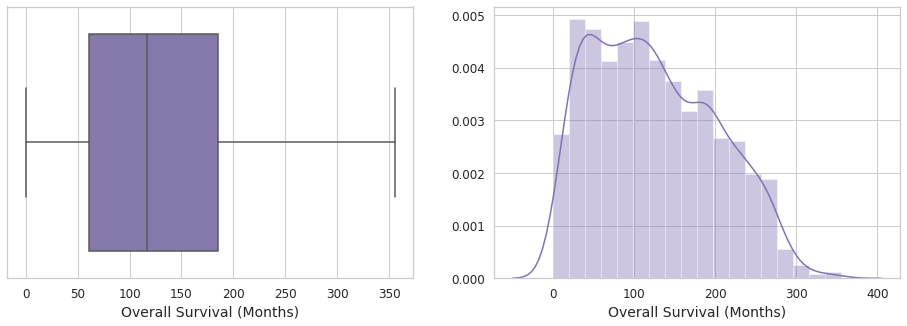

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.boxplot(overall_survival_month, palette=["m", "g"], ax=axs[0])
sns.distplot(overall_survival_month, color="m", ax=axs[1])

Let's look at how many values lying before five years border? (The five-year survival rate is a typical measurement for diseases).

Link: https://en.wikipedia.org/wiki/Five-year_survival_rate

In [8]:
overall_survival_month.where(overall_survival_month < 60).count()

491

And how many of them haму 'Living' status ?

In [9]:
df.where((df["Overall Survival (Months)"] < 60.) & (df["Patient's Vital Status"] == 'Living'))["Patient's Vital Status"].count()

64

So, we got 64 living patients. If we exclude them, we will get only patients that survived more than 5 years or the ones who died before. 

In [10]:
df = df.drop(df[(df["Overall Survival (Months)"] < 60.) & (df["Patient's Vital Status"] == 'Living')].index)

In [11]:
print(f'Number of patients with known 5 year status: {df.shape[0]}')

Number of patients with known 5 year status: 1916


Now we can drop "Overall Survival (Months)" feature and proceed further with "Patient's Vital Status" as a target

In [12]:
df = df.drop(columns=["Overall Survival (Months)"])

## Target encoding

Now, we need to change our target to chosen (Living/Dead) status. Let's take a look at its values:

In [13]:
df["Patient's Vital Status"].value_counts()

Living                  773
Died of Disease         646
Died of Other Causes    497
Name: Patient's Vital Status, dtype: int64

Ok, so all we have to do is sum up 'Died' statuses and then change strings to int:

In [14]:
df["Patient's Vital Status"] = df["Patient's Vital Status"].map({
    'Died of Disease': 0,
    'Died of Other Causes': 0,
    'Living': 1
})

In [15]:
df["Patient's Vital Status"].value_counts()

0    1143
1     773
Name: Patient's Vital Status, dtype: int64

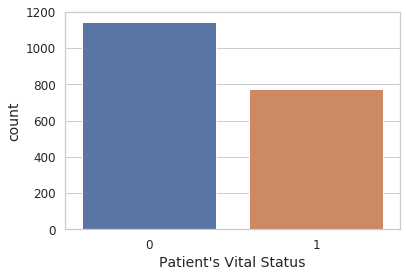

In [16]:
ax = sns.countplot(df["Patient's Vital Status"], label="Patient's Vital Status")

# Identify quality issues

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1916 entries, 0 to 1984
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Study ID                        1916 non-null   object 
 1   Patient ID                      1916 non-null   object 
 2   Sample ID                       1916 non-null   object 
 3   Age at Diagnosis                1916 non-null   float64
 4   Type of Breast Surgery          1896 non-null   object 
 5   Cancer Type                     1916 non-null   object 
 6   Cancer Type Detailed            1875 non-null   object 
 7   Cellularity                     1853 non-null   object 
 8   Chemotherapy                    1915 non-null   object 
 9   Pam50 + Claudin-low subtype     1915 non-null   object 
 10  Cohort                          1916 non-null   float64
 11  ER status measured by IHC       1876 non-null   object 
 12  ER Status                       19

There are a lot of missing values in the columns, wrong types, columns that do not fit our problem (only initial tests result), duplicated columns, e.t.c. 

The ETL process definitely won't be easy.

# Assess feature quality

This part is transfered to the ETL notebook for the better clarity of the process

# Get an idea on the value distribution of your data using statistical measures and visualizations

Despite the fact that we got a lot of unrelevant and duplicated data and missing values, we still can take a first look at data stats and distributions.

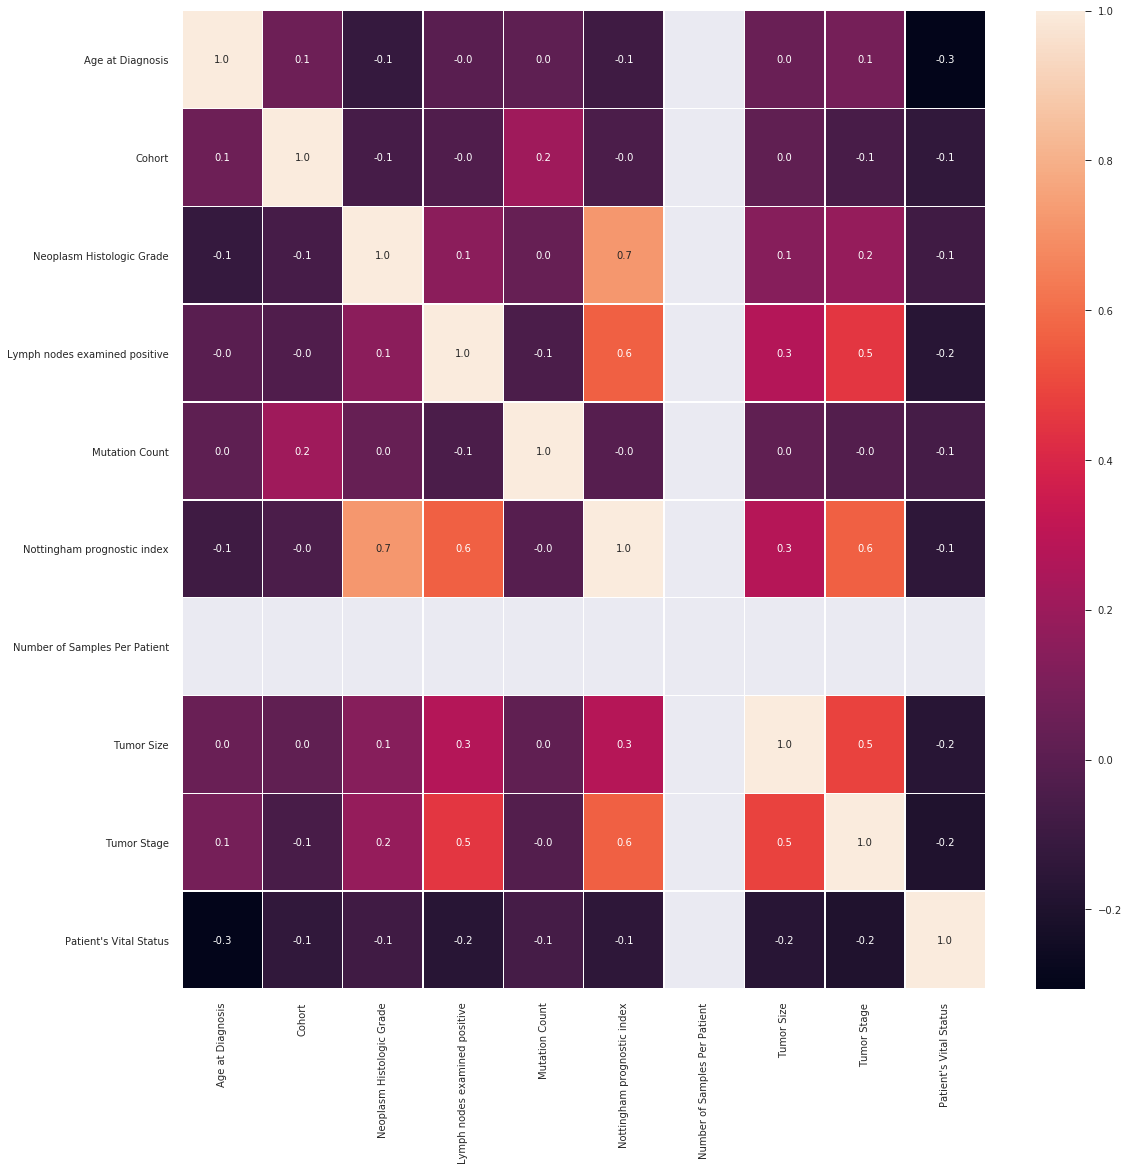

In [27]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

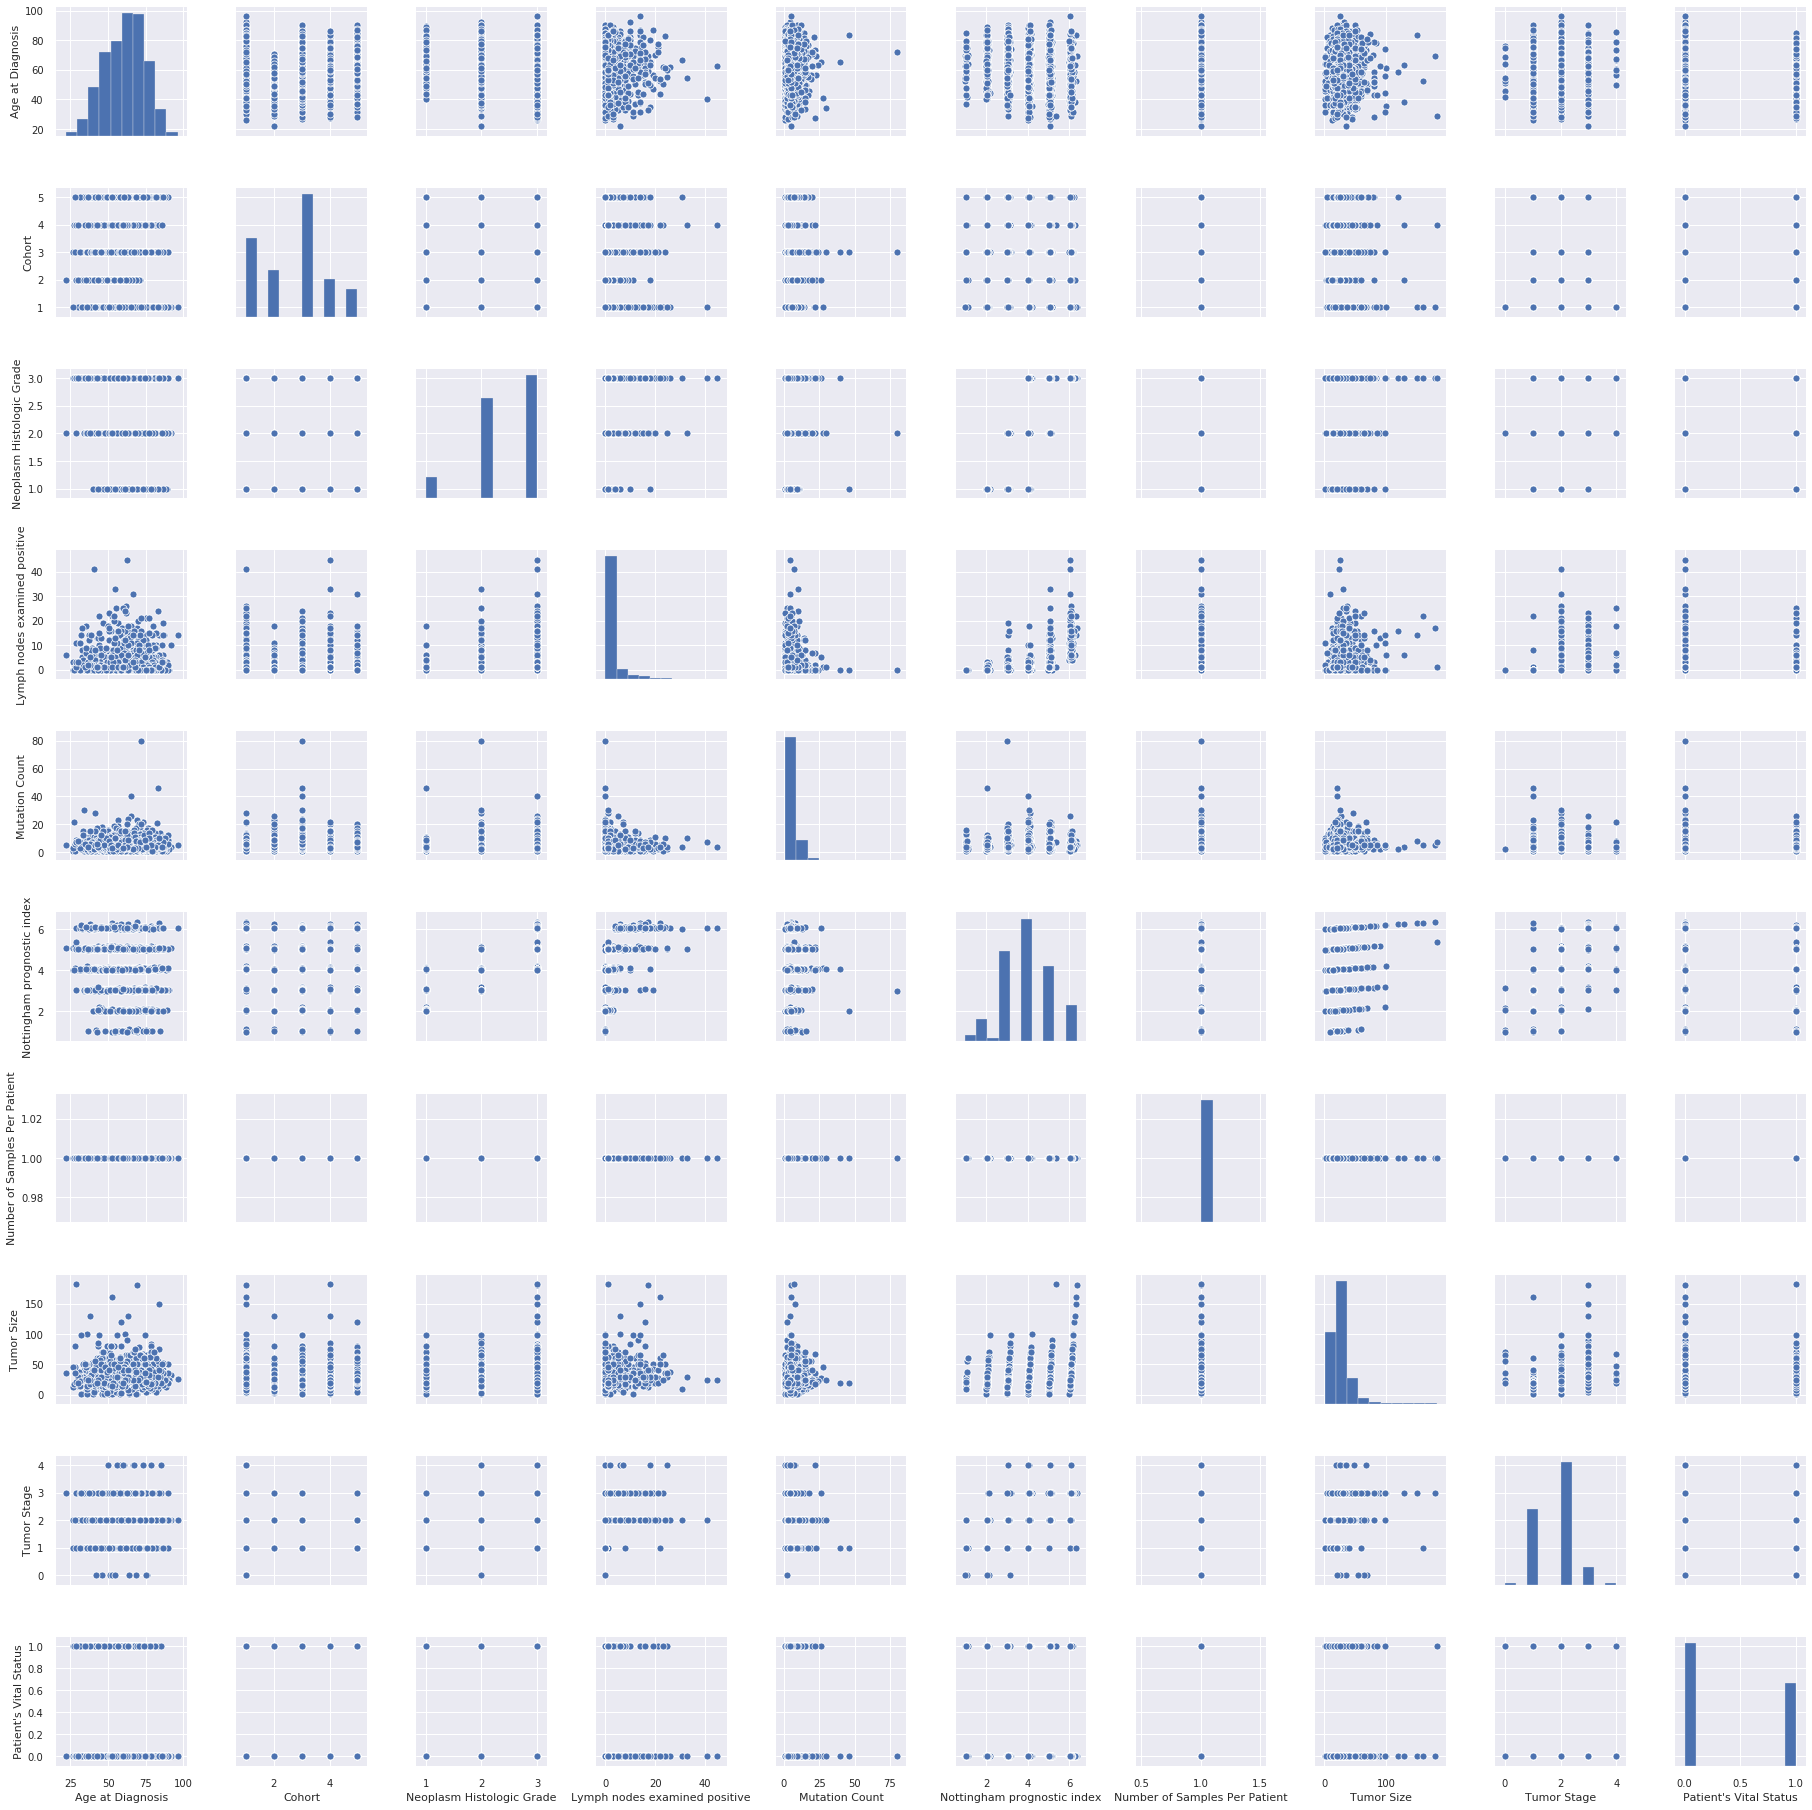

In [28]:
sns.pairplot(df, dropna=True)

That's sums up initial notebook. 

# Data upload

In [32]:
credentials = {
    'IAM_SERVICE_ID': '',
    'IBM_API_KEY_ID': '',
    'ENDPOINT': '',
    'IBM_AUTH_ENDPOINT': '',
    'BUCKET': '',
    'FILE': ''
}

In [33]:
from ibm_botocore.client import Config
import ibm_boto3

In [34]:
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

In [37]:
export_csv = df.to_csv('data/init_data.csv', index = None, header=True)

In [38]:
cos.upload_file(Filename='data.csv',Bucket=credentials['BUCKET'],Key='data.csv')

In [40]:
cos.download_file(Bucket=credentials['BUCKET'],Key='data.csv',Filename='init_copy.csv')

In [41]:
test = pd.read_csv('init_copy.csv')

In [43]:
test.head()

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,...,Oncotree Code,Overall Survival Status,PR Status,Radio Therapy,Number of Samples Per Patient,Sample Type,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,brca_metabric,MB-0000,MB-0000,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,...,IDC,LIVING,Negative,YES,1,Primary,ER-/HER2-,22.0,2.0,1
1,brca_metabric,MB-0002,MB-0002,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,LumA,...,IDC,LIVING,Positive,YES,1,Primary,ER+/HER2- High Prolif,10.0,1.0,1
2,brca_metabric,MB-0005,MB-0005,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,YES,LumB,...,IDC,DECEASED,Positive,NO,1,Primary,NaN,15.0,2.0,0
3,brca_metabric,MB-0006,MB-0006,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,YES,LumB,...,MDLC,LIVING,Positive,YES,1,Primary,NaN,25.0,2.0,1
4,brca_metabric,MB-0008,MB-0008,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,...,MDLC,DECEASED,Positive,YES,1,Primary,ER+/HER2- High Prolif,40.0,2.0,0
